In [1]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.ndimage import convolve
from scipy import misc
import pandas as pd

In [2]:
sigma=1.4
kernel_size=5
lowthreshold=0.09
highthreshold=0.17
strong_pixel=255
weak_pixel=100
img_smoothed = None
gradientMat = None
thetaMat = None
nonMaxImg = None
thresholdImg = None

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

def threshold(img):
    global highthreshold
    global lowthreshold
    global strong_pixel
    global weak_pixel
    highThresholdP = img.max() * highthreshold;
    lowThresholdP = highThresholdP * lowthreshold;
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    weak = np.int32(weak_pixel)
    strong = np.int32(strong_pixel)
    strong_i, strong_j = np.where(img >= highThresholdP)
    zeros_i, zeros_j = np.where(img < lowThresholdP)
    weak_i, weak_j = np.where((img <= highThresholdP) & (img >= lowThresholdP))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return (res)

def hysteresis(img):
    global strong_pixel
    global weak_pixel
    M, N = img.shape
    weak = weak_pixel
    strong = strong_pixel
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

def canny_preprocessing(img):
    img_smoothed = convolve(img, gaussian_kernel(kernel_size, sigma))
    gradientMat, thetaMat = sobel_filters(img_smoothed)
    nonMaxImg = non_max_suppression(gradientMat, thetaMat)
    thresholdImg = threshold(nonMaxImg)
    img_final = hysteresis(thresholdImg)
    return img_final


In [3]:
path = "/Users/dhatrirukkannagari/Desktop/HackUTA/asl_dataset"

import os 
import cv2

In [4]:
myList = os.listdir(path)
myList.remove(".DS_Store")
#myList

In [5]:
#myList
category_index={"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"a":10,"b":11,"c":12,"d":13,"e":14,"f":15,"g":16,"h":17,"i":18,"j":19,"k":20,"l":21,"m":22,"n":23,"o":24,"p":25,"q":26,"r":27,"s":28,"t":29,"u":30,"v":31,"w":32,"x":33,"y":34,"z":35}
categories=["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]


In [6]:
category_index[categories[0]]

0

In [7]:
a=[]
image_label=[]

for category in categories:
    folder_path=os.path.join(path,category) 
    # print(folder_path)
    images=os.listdir(folder_path) 
    print("--------------------------------")
    # print(len(images[0]))
    print(f'Loading images of the category {category}.\n No. of images in this category are: {len(images)}')
    print("--------------------------------")
    for image in images:
        img_path=os.path.join(folder_path,image)
        #print(img_path)
        try:
            img=cv2.imread(img_path)
            img=rgb2gray(img)
            preprocessed_img=canny_preprocessing(img)
            a.append(preprocessed_img)
            image_label.append(category_index[category])
        except:
            pass


--------------------------------
Loading images of the category 0.
 No. of images in this category are: 70
--------------------------------
--------------------------------
Loading images of the category 1.
 No. of images in this category are: 70
--------------------------------
--------------------------------
Loading images of the category 2.
 No. of images in this category are: 70
--------------------------------
--------------------------------
Loading images of the category 3.
 No. of images in this category are: 70
--------------------------------
--------------------------------
Loading images of the category 4.
 No. of images in this category are: 70
--------------------------------
--------------------------------
Loading images of the category 5.
 No. of images in this category are: 70
--------------------------------
--------------------------------
Loading images of the category 6.
 No. of images in this category are: 70
--------------------------------
--------------------

In [8]:
len(a)

2515

In [9]:
len(image_label)

2515

In [10]:
import numpy as np
a=np.array(a)
labels=np.array(image_label)

In [11]:
a.shape,labels.shape

((2515, 400, 400), (2515,))

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(a,labels,test_size=0.1,random_state=19)

In [13]:
numOfCategories=36

from keras.utils import to_categorical
y_train=to_categorical(y_train,numOfCategories)
y_test=to_categorical(y_test,numOfCategories)

In [14]:
X_train.shape, y_train.shape

((2263, 400, 400), (2263, 36))

In [15]:
X_test.shape, y_test.shape

((252, 400, 400), (252, 36))

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import BatchNormalization

In [17]:
model=Sequential()

model.add(Conv2D(64,kernel_size=(3,3),input_shape=(400, 400, 1),activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),input_shape=(400, 400, 1),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(512,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(512,kernel_size=(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))



model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(36,activation="softmax"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 398, 398, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 396, 396, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 396, 396, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 198, 198, 64)      0         
 D)                                                              
                                                        

In [19]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [20]:
history=model.fit(X_train,y_train,batch_size=50,epochs=5,validation_data=(X_test,y_test))


Epoch 1/5
46/46 [==============================] - 1684s 37s/step - loss: 2.9994 - accuracy: 0.3354 - val_loss: 180.8767 - val_accuracy: 0.0754
Epoch 2/5
46/46 [==============================] - 1508s 33s/step - loss: 0.8033 - accuracy: 0.7671 - val_loss: 18.5227 - val_accuracy: 0.2738
Epoch 3/5
46/46 [==============================] - 1793s 39s/step - loss: 0.4828 - accuracy: 0.8502 - val_loss: 7.6470 - val_accuracy: 0.3810
Epoch 4/5
46/46 [==============================] - 1486s 32s/step - loss: 0.2989 - accuracy: 0.9037 - val_loss: 1.2959 - val_accuracy: 0.7262
Epoch 5/5
46/46 [==============================] - 1594s 35s/step - loss: 0.2626 - accuracy: 0.9125 - val_loss: 0.5527 - val_accuracy: 0.8611


In [21]:
#Saving the model
model_json=model.to_json()
with open("asl_model.json","w") as json_file:
    json_file.write(model_json)
    #serializing weights to HDF5
model.save_weights("asl_model.h5")

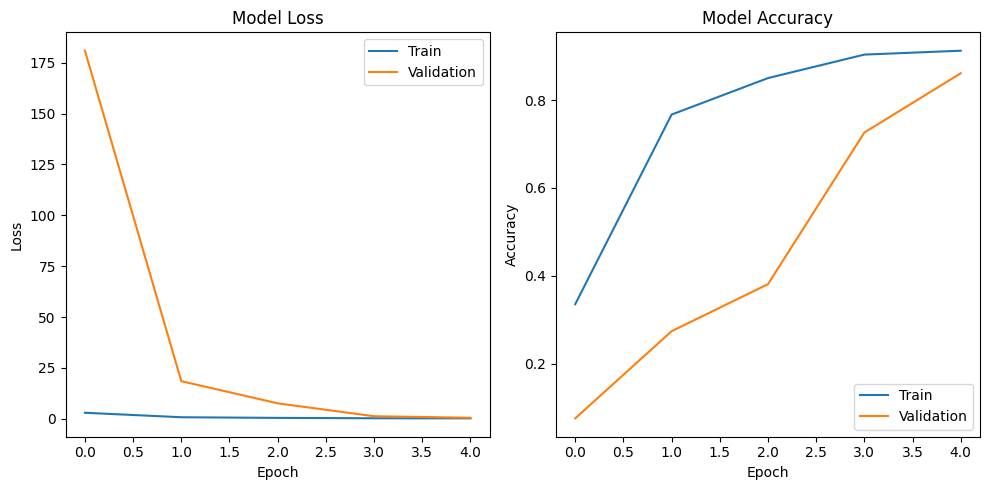

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()
